# Recurrent Neural Network


A Recurrent Neural Network(RNN) is a type of neural network that considers past data points into its input values to create an output value. This neural network is primarily used for sequential data such as language models or time series data. The way it works is it inputs sequentially. Here is how a standard RNN works: We first input the first data point into the RNN, then it produces an output from the data point, like a standard forwardfeed neural network. In addition, traversing the neural network will also create a hidden state, where it will be used for the next data point. Thus, in the end, after traversing the entire sequential dataset, we will have got an output that is created from many hidden states created from our datapoints. We call the entire process of inputting values into the neural network and creating outputs from it the control flow of the network.

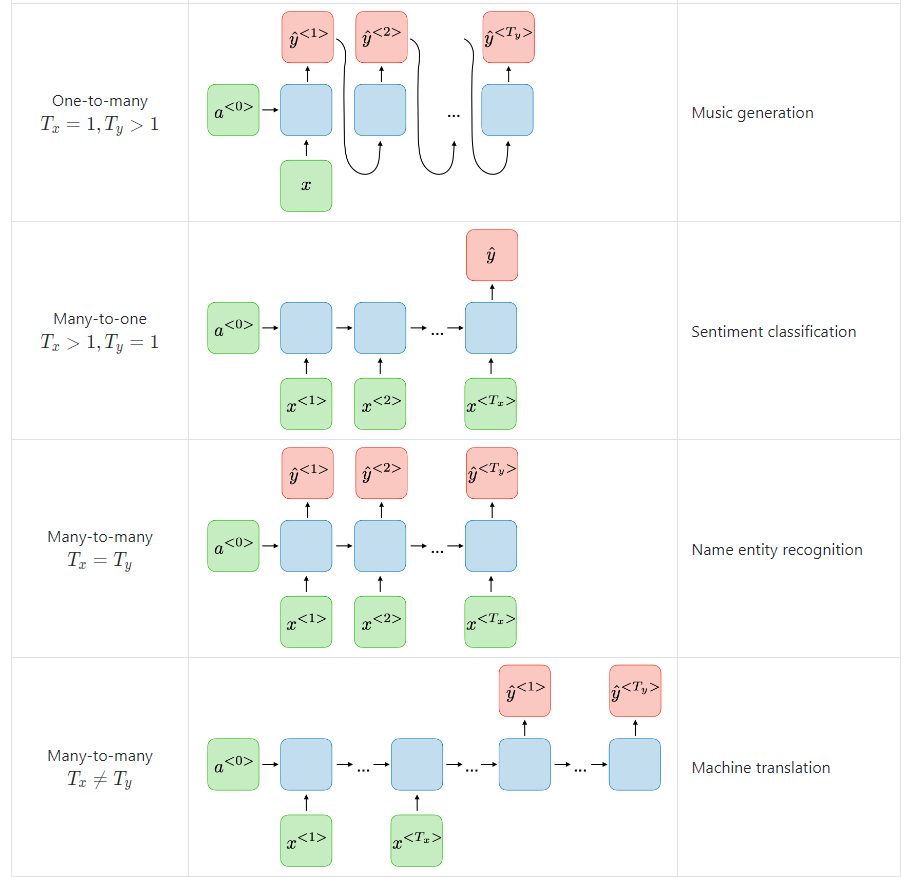

With regards to optimizing the neural network weights, we use backpropagation by optimizing the loss function, by computing the gradient $\nabla C = (\frac{\partial}{\partial x_1}, \frac{\partial}{\partial x_2}, \dots, \frac{\partial}{\partial x_n})$, where $C$ is the loss function. It follows that some neurons are made up of many different neurons, thus there would be many different weights that are applied to these many neurons to create the resulting neuron. Thus, to compute the partial derivative of that output neuron, it follows that we need to use the chain rule, which multiplies the partial derivatives of each consecutive weight. Recall the chain rule: $\frac{dy}{dx} = \frac{dy}{dt}\frac{dt}{dx}$, which describes a change in $x$ creates a change in $t$, which ultimately creates a change in $y$. 

In neural networks, we also implement activation functions so that we can describe non-linear relationships in the neural network. The reason why we often use activation functions such as tanh, sigmoid, and ReLU, and not functions such as the quadratic or exponential, is that we also want to scale the function, usually between 0 and 1, so that when we do backpropagation and take the derivative of the activation functions, we will not multiply the derivative by a factor of a large number via the chain rule, and get an exploding gradient. If we do get an exploding gradient, it follows that when we perform gradient descent, the results will be very inaccurate, and the loss function will drastically change, even in the positive direction, which is what we do not want when training a neural network.

However, even when using common activation functions, we can also encounter vanishing gradients, where the gradient converges to 0. This is caused by multiplying via chain rule, multiple values close to 0. We achieve these values when, for example, in the tanh function, we get multiple values which are located on the flat-like part of the function on the far left or far right of the function, in which the derivative of that part of the function(the slope of the tangent line at that point) is close to 0. In the exploding and vanishing gradient cases, both are caused by having many different input values for each neuron in the neural network.

Going back to RNNs, we can see that because not only we consider the previous neurons in the neural network when traversing the neural network, we also consider the hidden states of the network, created by previous inputs from the sequential data. The larger the sequential data, the more inputs and hidden states of the network, and because we commonly get vanishing gradients as RNNs typically use the tanh functions, the neural network will experience short-term memory. This means that some partial derivatives become insignificant to the gradient, as these partial derivatives will equal to 0, and thus when training the neural network, these parts where the partial derivative equals to 0, usually previous hidden states, will not have any changes to their weights, effectively 'losing their memory' from the network. This is a problem as sometimes, especially seasonal data, rely on information inputted from a long time ago, thus we need LSTMs and GRUs, which are variations to the recurrent neural network that provides a solution to this problem.

### Long Short Term Memory(LSTM) Model

LSTMs have the same control flow as the RNN; it receives data points sequentially, and uses hidden states to be used for the next input. The difference is the operations performed inside each RNN cell, or input, which controls which values of the input and previous hidden states to keep and which values to forget. An LSTM can be split into 4 different components, each can be its own neural network: The forget gate, the input gate, the cell state, and the output gate. 

When the input enters into the LSTM, as with RNNs, the input and the hidden state from previous inputs is added together, and first enters the forget gate. The forget gate determines what information to keep and what information to forget, determined by the sigmoid function, which scales the input and the hidden state to a number between 0 and 1. The closer to 0, the information will be forgotten, and the closer to 1, the information will be kept. The linear combination of the hidden state and the input will also enter into the input gate, where it encounters a sigmoid and a tanh function, and the output will decide which information to keep relative to the output of the tanh function. The cell state is the core element of the LSTM model, as it stores relevant long-term information about our inputs. First, the cell state encounters the forget gate output, which decides what information from previous inputs to forget(irrelevant info). Then, it encounters the input gate, where relevant information from our current input is added to the cell state. The last component of the model is the output gate, where it decides what information will be used for the next hidden state, based on the output value of the cell state transformed by the tanh function. 

TLDR: The forget gate decides what information to keep in the cell state, the input gate decides what information to add to the cell state, and the output gate decides what will the hidden state be in the next LSTM cell. The cell state retains relevant long-term information about the sequential data.

#### Implementing LSTM

To implement an LSTM model, we must normalize the data such that all the data fits into the range between 0 and 1 so that it will be easier for the machine to interpret values and perform efficient optimization. 

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from keras import layers, callbacks
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape

In [ ]:
# Normalization

scaler = MinMaxScaler()
temp = df.copy()
temp['value'] = scaler.fit_transform(pd.DataFrame({'values': temp['value']}))

We then convert the time series into a classification problem by creating new feature variables for the previous values of the target variable, as well as new target variables for forecasting. When deciding the amount of forecast variables, we want to keep in mind that forecasting less values is more accurate than forecasting many values, so we need to find the balance in that.

In [ ]:
# We create a new dataframe that contains variables of all timestamps we want, then we split the dataframe into two dataframes:
# One for feature variables(previous values) and one for target variables(forecasting)

def series_to_supervised(df, time_in, time_out):
    temp = pd.DataFrame({'t': df['value']})
    for i in range(1, time_in+1):
        temp[f't-{i}'] = temp['t'].shift(i)
    for i in range(1, time_out+1):
        temp[f't+{i}'] = temp['t'].shift(-i)
    temp = temp.dropna()
    return temp

new_df = series_to_supervised(temp, 100, 10) # Use previous 100 data points to forecase 10 data points in the future
X, y = new_df[list(new_df.filter(regex='-').columns)], new_df[['t']+list(new_df.filter(like='t+').columns)]

As usual with classification problems, we split the dataset into training, validation, and testing data. The split will depend on the time series data given. If we have seasonal data, we want to make sure that our training data captures all forms of seasonality.

In [ ]:
# Split data into training, validation, and testing data
# 70:30 split, then 80:20 split on 70%

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

We now are ready to train our LSTM model with our data. We will train the data using the sliding window technique: we use previous values to predict future values, then after each iteration, we move the interval of previous timestamps up by one to predict the next future values. We could also train the data using the block time series splitting technique, where we split the data into partitions, and use those partitions to predict future values. Note that the block time series may be more efficient, as there is no data overlap, however it might be less accurate as the sliding window technique as we will not be able to train as many datapoints as possible.

In [ ]:
# Training LSTM model using the sliding window technique

model = keras.Sequential([
    layers.LSTM(64, activation='tanh', input_shape=(X_train.shape[1], 1), return_sequences=True),
    layers.LSTM(32, activation='tanh'), # activation function as tanh function to prevent exploding gradients
    layers.Dense(y_train.shape[1])
])
model.compile(optimizer='adam', loss='mae') # Use adam optimizer and mean absolute error as loss function

early_stopping = callbacks.EarlyStopping(
    min_delta=0.01,
    patience=50, 
    restore_best_weights=True
)

model.summary()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[early_stopping], epochs=500, batch_size=32)

After completing the training, we can use the model to predict and forecast values into the future

In [ ]:
# Prepare dataset for prediction. For our prediction, we will use the block time series split. Use technique for model training
# if choosing to use this technique instead of the sliding window technique

X_pred = pd.DataFrame()
y_pred = pd.DataFrame()
test = series_to_supervised(temp, 100, 10)
X_test, y_test = test[list(test.filter(regex='-').columns)], test[['t']+list(test.filter(like='t+').columns)]
for i in range(0, len(X_test), 662):
    X_pred = pd.concat([X_pred, pd.DataFrame(X_test.iloc[i]).transpose()])
    y_pred = pd.concat([y_pred, pd.DataFrame(y_test.iloc[i]).transpose()])

In [ ]:
# Predictions, model evaluation using mean absolute error and mean absolute percentage error

predictions = model.predict(X_pred)
predictions = pd.DataFrame(predictions, columns=y_pred.columns, index=y_pred.index)
print("Mean Absolute Error: ", mae(y_pred, predictions))
print("Mean Absolute Percentage Error: ", mape(y_pred, predictions))

We want to visualize the results of our forecasting model. Remember that we have normalized our data before we started to train the model, thus we must inverse the normalization transformation so that we get our actual values of our prediction.

In [ ]:
# Convert the predictions dataframe so that all our predicted values end up in one single column

indexes = []
for index in predictions.index:
    indexes.append(pd.date_range(index, periods=10, freq='H')) # 10 hours into the future
a = pd.DataFrame()
for index in indexes:
    b = pd.DataFrame(index=index)
    a = pd.concat([a, b])
predictions = np.array(predictions).ravel()
a['Predictions'] = predictions

In [ ]:
# Inverse normalization transform on predictions

a['Predictions'] = scaler.inverse_transform(pd.DataFrame({'values': a['Predictions']}))

In [ ]:
# Plot results 

plt.figure(figsize=(12, 6))
plt.plot(df['values'])
plt.plot(a['Predictions'])
plt.legend(['Actual', 'Forecast Predictions'])
plt.title("LSTM Forecast Predictions vs Actual Values")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

### Gated Recurrent Units(GRU) Model

Gated Recurrent Units are very similar to LSTMs. The difference is that the GRU does not have a cell state; instead they rely on the hidden state to retain and transfer information. Because of this, GRUs have less tensor operations, therefore they perform quicker than LSTMs. So, data scientists will use both GRUs and LSTMs to compare results. In addition, GRUs have two gates: the reset gate and the update gate. The update gate is similar to the forget gate and the input gate, in the sense that it is used to decide what information to keep and what information to keep to the hidden state. The reset gate is used to decide what information from the past should be forgotten.